In [1]:
import torch
import numpy as np
import pickle
from openai import OpenAI
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
with open("data/190325_data.pkl", "rb") as f:
    train_chat_data = pickle.load(f)
    
# Remove service chat
del train_chat_data[-1000]

In [4]:
with open("data/100925_data.pkl", "rb") as f:
    chat_data = pickle.load(f)
    
# Remove service chat
del chat_data[-1000]

In [5]:
messages = []
labels = []
game_ids = []
user_ids = []
languages = []
for game_id, game_data in chat_data.items():
    if game_id in train_chat_data.keys():
        continue
    for message in game_data["messages"]:
        if message["userID"] == "GameMaster":
            if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                break
            else:
                continue
        messages.append(message["message"])
        labels.append([int(not message["botID"]), message["botID"]])
        game_ids.append(message["gameID"])
        user_ids.append(message["userID"])
        if game_data["language"] is None:
            languages.append("en")
        else:
            languages.append(game_data["language"])
        
print(len(messages))
print(len(labels))

9631
9631


In [6]:
class NaiveBayesClassifier:
    def __init__(self, path_to_state_dict):
        class MessageClassifier(torch.nn.Module):
            def __init__(self, input_size, hidden_sizes, output_size, dropout=0.75):
                super().__init__()
                self.activation = torch.nn.ReLU()
                layers = []
                current_size = input_size
                for hidden_size in hidden_sizes:
                    layers.append(torch.nn.Linear(current_size, hidden_size))
                    layers.append(torch.nn.BatchNorm1d(hidden_size))
                    layers.append(torch.nn.ReLU())
                    layers.append(torch.nn.Dropout(dropout))
                    current_size = hidden_size
                layers.append(torch.nn.Linear(current_size, output_size))
        
                self.model = torch.nn.Sequential(*layers)
        
            def forward(self, x):
                return self.model(x)

        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.client = OpenAI(
                            api_key="EMPTY",
                            base_url="http://localhost:8000/v1"
                        )
        self.embedding_model = "intfloat/multilingual-e5-large-instruct"

        self.classifier = MessageClassifier(1024, [48, 24], 2, dropout=0.85)
        self.classifier.to(self.device)
        self.classifier.load_state_dict(torch.load(path_to_state_dict, weights_only=True))
        self.classifier.eval()

    def predict(self, message: str):
        # Classifies a message as human (negative score) or bot (positive score).
        embedding = torch.tensor(self.client.embeddings.create(input = [message], model=self.embedding_model).data[0].embedding)
        pred = self.classifier(embedding.unsqueeze(dim=0)).squeeze()
        return (pred[1]-pred[0]).item()
            

In [7]:
classifier = NaiveBayesClassifier("models/run082.pth")

In [8]:
classifier.predict("test")
classifier.predict("bot")
classifier.predict("hi")
classifier.predict("hey guys how are you")

-2.65248703956604

In [9]:
messages_with_i_dont_know= []
user_ids_with_i_dont_know = []
messages_with_idk = []
user_ids_with_idk = []
for message, user_id in zip(messages, user_ids):
    if "i dont know" in message:
        messages_with_i_dont_know.append(message)
        user_ids_with_i_dont_know.append(user_id)
    
    if "idk" in message:
        messages_with_idk.append(message)
        user_ids_with_idk.append(user_id)

In [10]:
for user_id, message in zip(user_ids_with_idk[:3], messages_with_idk[:3]):
    print(message)
    print(classifier.predict(message))
    print("After changing")
    print(message.replace("idk", "i don't know"))
    print(classifier.predict(message.replace("idk", "i don't know")))

idk, cant just guess
1.6309330463409424
After changing
i don't know, cant just guess
1.3250558376312256
idk bro
-1.5366469621658325
After changing
i don't know bro
-0.7560179233551025
idk
-1.837700605392456
After changing
i don't know
-2.0457558631896973


In [11]:
messages_with_how_about_you= []
user_ids_with_how_about_you = []
messages_with_hbu = []
user_ids_with_hbu = []

message_with_bot = []
user_ids_with_bot = []
for message, user_id in zip(messages, user_ids):
    if "how about you" in message:
        messages_with_how_about_you.append(message)
        user_ids_with_how_about_you.append(user_id)
    
    if "hbu" in message:
        messages_with_hbu.append(message)
        user_ids_with_hbu.append(user_id)
    if "bot" in message:
        message_with_bot.append(message)
        user_ids_with_bot.append(user_id)

In [12]:
print(classifier.predict("how about you"))
print(classifier.predict("hbu"))

-1.2802646160125732
-3.184713363647461


In [13]:
for user_id, message in zip(user_ids_with_how_about_you[:3], messages_with_how_about_you[:3]):
    print(message)
    print(classifier.predict(message))
    print("After changing")
    print(message.replace("how about you", "hbu"))
    print(classifier.predict(message.replace("how about you", "hbu")))

how about you, Red?
0.13095107674598694
After changing
hbu, Red?
0.3028487265110016
I enjoy action movies how about you
4.188089370727539
After changing
I enjoy action movies hbu
1.6950793266296387
I like espresso mostly, how about you?
2.2999796867370605
After changing
I like espresso mostly, hbu?
2.514404773712158


In [14]:
for user_id, message in zip(user_ids_with_hbu[:4], messages_with_hbu[:4]):
    print(message)
    print(classifier.predict(message))
    print("After changing")
    print(message.replace("hbu", "how about you"))
    print(classifier.predict(message.replace("hbu", "how about you")))

red hbu
-2.7308268547058105
After changing
red how about you
-2.0165741443634033
its lexie ditchburn
-1.5671110153198242
After changing
its lexie ditchow about yourn
-1.7464357614517212
good hbu
-2.089043140411377
After changing
good how about you
-1.4912000894546509
hbu?
-1.5022770166397095
After changing
how about you?
-1.3939704895019531


In [15]:
for user_id, message in zip(user_ids_with_bot[:10], message_with_bot[:10]):
    print(message)
    print(classifier.predict(message))
    #print("After changing")
    #print(message.replace("how about you", "hbu"))
    #print(classifier.predict(message.replace("how about you", "hbu")))

total = 0
for message in message_with_bot:
    total += classifier.predict(message)
print(f"Messages with 'bot' got an average score of {total/len(message_with_bot)}")

Who is the bot?
-3.9564385414123535
Hi Blue. Would you agree that yellow os the bot?
-1.611377239227295
So let's play the game! Who is the bot?
-2.1624462604522705
so you are human or bot
-3.2869205474853516
are you was on human or bot
-3.148477554321289
 i dont mean somthing but there was a same name and same country on chat or bot 
-0.303500771522522
What do you both work? I already told you my work, so please tell me yours.
-1.5244137048721313
ok both of you convince me you are human
-2.441359519958496
na dann bist Du @Purple ein KI Chatbot?
-3.7053639888763428
cool, hey bot, what is your opinion about that
-1.149780035018921
Messages with 'bot' got an average score of -2.151104892840226


In [16]:
random.seed(42)
i = 0
while i < 5:
    idx = random.randint(0, len(messages)-1)
    message = messages[idx]
    user_id = user_ids[idx]
    if user_id != '0':
        continue
    print(message)
    print(classifier.predict(message))
    print("After changing")
    message = message + " bot"
    print(message)
    print(classifier.predict(message))
    i += 1

yeah im here
-0.3300672769546509
After changing
yeah im here bot
-1.8590456247329712
fajnie tam


-1.2335546016693115
After changing
fajnie tam bot
-1.6671712398529053
what do you like to do
-0.1263180673122406
After changing
what do you like to do bot
-1.7560027837753296
ok, weiter gehts
0.5398737192153931
After changing
ok, weiter gehts bot
-1.7745866775512695
ach so, dann vergiss es.
-1.5488241910934448
After changing
ach so, dann vergiss es. bot
-1.769914150238037


In [17]:
print(message_with_bot[9])
print(len(message_with_bot))

cool, hey bot, what is your opinion about that
209


In [19]:
def get_player_scores(classifier, threshold=1):
    with open("data/190325_data.pkl", "rb") as f:
        chat_data = pickle.load(f)

    with open("data/100925_data.pkl", "rb") as f:
        test_data = pickle.load(f)

    evaluated_ids = []
    player_scores_per_game = []
    for game_id in tqdm(test_data.keys(), desc="Evaluating", total=len(test_data.keys())):
        if game_id in chat_data.keys():
            continue
        game = test_data[game_id]
        evaluated_ids.append(game_id)
        player_scores = defaultdict(float)
        
        for message in game["messages"]:
            if message["userID"] == "GameMaster":
                if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                    break
                else:
                    continue
            else:
                if message["botID"]:
                    player_scores["bot"] += classifier.predict(message["message"])
                else:
                    player_scores[message["color"]] += classifier.predict(message["message"])        

        if "bot" not in player_scores.keys():
            player_scores["bot"] = 0
        while len(player_scores.keys()) < 3:
            player_scores[f"simulated_player_{3-len(player_scores.keys())}"] = 0
        
        player_scores_per_game.append(player_scores)
    return player_scores_per_game, evaluated_ids

In [20]:
def evaluate_on_old_games(player_scores_per_game, threshold=1):
    true_positives = 0
    false_positives = 0
    false_game_ids = []
    false_negative = 0

    with open("data/corresponding_game_ids.pkl", "rb") as f:
        game_ids = pickle.load(f)

    for game_scores, game_id in zip(player_scores_per_game, game_ids):

        colors = list(game_scores.keys())
        for player in colors:
            if player == "bot":
                continue

            bot_score = game_scores["bot"]
            human_score = game_scores[player]

            if bot_score - human_score > threshold:
                # Classifier would accuse the bot
                true_positives += 1
            elif human_score - bot_score > threshold:
                # Classifier would accuse a human
                false_positives += 1
                false_game_ids.append(game_id)
            else:
                # No accusation
                false_negative += 1
                false_game_ids.append(game_id)
    return true_positives, false_positives, false_negative, false_game_ids

In [21]:
player_scores_per_game, game_ids = get_player_scores(classifier)
with open("data/precomputed_player_scores.pkl", "wb") as f:
    pickle.dump(player_scores_per_game, f)
with open("data/corresponding_game_ids.pkl", "wb") as f:
    pickle.dump(game_ids, f)

Evaluating: 100%|██████████| 2421/2421 [14:57<00:00,  2.70it/s] 


In [22]:
print(f"Evaluated {len(game_ids)} games")

Evaluated 861 games


In [23]:
tp, fp, fn, false_game_ids_threshold_3= evaluate_on_old_games(player_scores_per_game, threshold=3)

In [24]:
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0.0
miss_rate = fn / (tp + fn) if (tp + fn) > 0 else 0.0

In [25]:
print(f"True Positives (TP):          {tp}")
print(f"False Positives (FP):         {fp}")
print(f"False Negatives (FN):         {fn}")
print()
print(f"Precision:                    {precision:.4f}")
print(f"Recall (TPR):                 {recall:.4f}")
print(f"F1 Score:                     {f1_score:.4f}")
print(f"False Discovery Rate (FDR):   {false_discovery_rate:.4f}")
print(f"Miss Rate (FNR):              {miss_rate:.4f}")

True Positives (TP):          1057
False Positives (FP):         50
False Negatives (FN):         617

Precision:                    0.9548
Recall (TPR):                 0.6314
F1 Score:                     0.7602
False Discovery Rate (FDR):   0.0452
Miss Rate (FNR):              0.3686


In [42]:
tp, fp, fn, false_game_ids_threshold_1 = evaluate_on_old_games(player_scores_per_game, threshold=5)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
false_discovery_rate = fp / (tp + fp) if (tp + fp) > 0 else 0.0
miss_rate = fn / (tp + fn) if (tp + fn) > 0 else 0.0
print(f"True Positives (TP):          {tp}")
print(f"False Positives (FP):         {fp}")
print(f"False Negatives (FN):         {fn}")
print()
print(f"Precision:                    {precision:.4f}")
print(f"Recall (TPR):                 {recall:.4f}")
print(f"F1 Score:                     {f1_score:.4f}")
print(f"False Discovery Rate (FDR):   {false_discovery_rate:.4f}")
print(f"Miss Rate (FNR):              {miss_rate:.4f}")

True Positives (TP):          908
False Positives (FP):         33
False Negatives (FN):         783

Precision:                    0.9649
Recall (TPR):                 0.5370
F1 Score:                     0.6900
False Discovery Rate (FDR):   0.0351
Miss Rate (FNR):              0.4630


In [29]:
with open("data/false_game_ids_threshold_1.pkl", "wb") as f:
    pickle.dump(false_game_ids_threshold_1, f)
with open("data/false_game_ids_threshold_3.pkl", "wb") as f:
    pickle.dump(false_game_ids_threshold_3, f)

In [30]:
def evaluate_threshold_curve(player_scores_per_game):
    thresholds = np.linspace(0, 5, 100)
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in thresholds:
        tp = 0
        fp = 0
        fn = 0

        for scores in player_scores_per_game:
            bot_score = scores["bot"]
            for player, human_score in scores.items():
                if player == "bot":
                    continue

                if bot_score - human_score > threshold:
                    tp += 1
                elif human_score - bot_score > threshold:
                    fp += 1
                else:
                    fn += 1

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label="Precision", color='blue')
    plt.plot(thresholds, recalls, label="Recall", color='green')
    plt.plot(thresholds, f1_scores, label="F1 Score", color='red')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Classifier Performance vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return thresholds, precisions, recalls, f1_scores

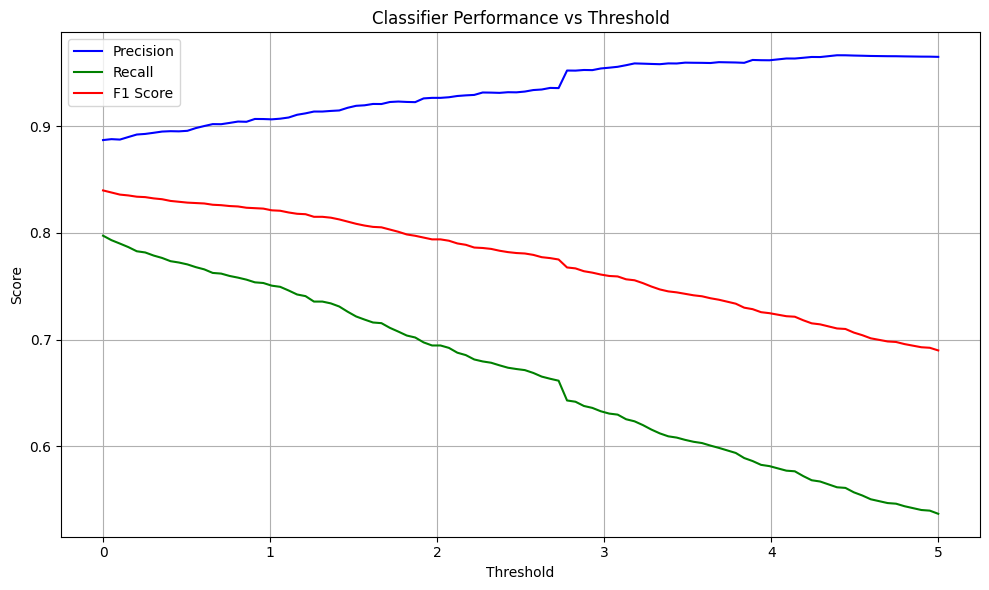

In [31]:
thresholds, precisions, recalls, f1_scores = evaluate_threshold_curve(player_scores_per_game)

In [32]:
with open("data/val_games_player_scores.pkl", "wb") as f:
    pickle.dump(player_scores_per_game, f)

In [33]:
def evaluate_thresholds_roc(player_scores_per_game, threshold_list):
    score_diffs = []
    labels = []

    for scores in player_scores_per_game:
        bot_score = scores["bot"]
        for player, human_score in scores.items():
            if player == "bot":
                continue
            score_diffs.append(bot_score - human_score)
            labels.append(1)

            score_diffs.append(human_score - bot_score)
            labels.append(0)

    score_diffs = np.array(score_diffs)
    labels = np.array(labels)

    fpr_base, tpr_base, _ = roc_curve(labels, score_diffs)
    roc_auc_base = auc(fpr_base, tpr_base)

    precision_base, recall_base, _ = precision_recall_curve(labels, score_diffs)
    pr_auc_base = auc(recall_base, precision_base)

    baseline_precision = np.mean(labels)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_base, tpr_base, label=f"Base ROC AUC = {roc_auc_base:.4f}", color="black", linestyle="--")
    plt.plot([0, 1], [0, 1], linestyle=":", color="gray", label="Random Classifier (Baseline)")

    for thresh in threshold_list:
        preds = (score_diffs >= thresh).astype(int)
        tp = np.sum((preds == 1) & (labels == 1))
        fp = np.sum((preds == 1) & (labels == 0))
        fn = np.sum((preds == 0) & (labels == 1))
        tn = np.sum((preds == 0) & (labels == 0))

        fpr = fp / (fp + tn) if (fp + tn) else 0
        tpr = tp / (tp + fn) if (tp + fn) else 0
        plt.scatter(fpr, tpr, label=f"Threshold {thresh:.2f}")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)



    plt.subplot(1, 2, 2)
    plt.plot(recall_base, precision_base, label=f"Base PR AUC = {pr_auc_base:.4f}", color="black", linestyle="--")
    plt.axhline(y=baseline_precision, color="gray", linestyle=":", label=f"Baseline Precision = {baseline_precision:.2f}")

    for thresh in threshold_list:
        preds = (score_diffs >= thresh).astype(int)
        tp = np.sum((preds == 1) & (labels == 1))
        fp = np.sum((preds == 1) & (labels == 0))
        fn = np.sum((preds == 0) & (labels == 1))

        precision = tp / (tp + fp) if (tp + fp) else 0
        recall = tp / (tp + fn) if (tp + fn) else 0
        plt.scatter(recall, precision, label=f"Threshold {thresh:.2f}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.ylim(-0.05, 1.05)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "base_roc_auc": roc_auc_base,
        "base_pr_auc": pr_auc_base,
        "baseline_precision": baseline_precision
    }


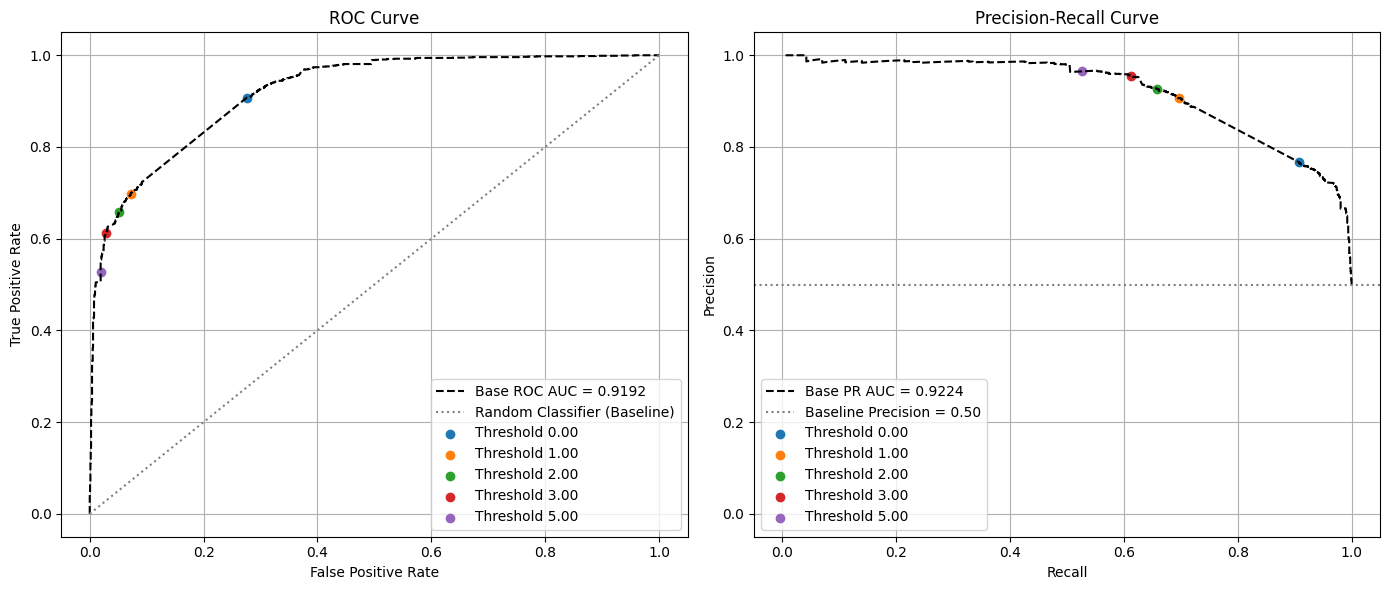

In [41]:
output = evaluate_thresholds_roc(player_scores_per_game, [0, 1, 2, 3, 5])

In [35]:
with open("data/false_game_ids_threshold_3.pkl", "rb") as f:
    wrong_indices = pickle.load(f)
    
val_games = game_ids

In [36]:
lengths = 0
long_wrong_games = []
for game in wrong_indices:
    game_messages = []
    game_data = chat_data[game]
    for message in game_data["messages"]:
        if message["userID"] == "GameMaster":
            if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                break
            else:
                continue
        game_messages.append(message["message"])
    lengths += len(game_messages)
    if len(game_messages) >= 10:
        long_wrong_games.append(game)

print(lengths/len(wrong_indices))

4.259370314842578


In [43]:
print(len(long_wrong_games))
print(len(wrong_indices))

64
667
